### My miniproject topic is training gan on a custom dataset, which uses the code given in the week 4.1 class.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Create a Tensorflow Dataset

Below we use the Keras `image_dataset_from_directory` to turn our folder full of images into a _Tensorflow dataset_ which will make loading images from the dataset much more efficient during training.


In [106]:
dataset = keras.preprocessing.image_dataset_from_directory(
    '/Users/zhudairun/Desktop/image/train',
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
#    seed=999,

)
dataset = dataset.map(lambda x: x / 255.0)

Found 75 files belonging to 1 classes.


In the cell below, we will get an image at random.

If we re-run the cell below we will see different images from the dataset.

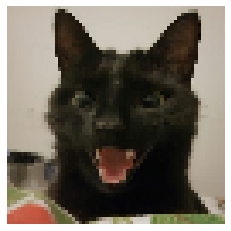

In [137]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Define the Discriminator

Here we use the _sequential_ API from Keras to define the discriminator model.

We can see that it 3 convolutional layers with leaky ReLU which is flattened and sent into a final fully connected layer with one output.



#### Here are some observations.

1.Changing the dropout data shows that the larger the value of dropout, the lower the brightness of the final generated image.

2.The smaller the value of the Conv2d layer, the clearer the image.

In [138]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(4, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(8, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(8, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.01),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 4)         196       
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 32, 32, 4)         0         
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 8)         520       
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 16, 16, 8)         0         
                                                                 
 conv2d_54 (Conv2D)          (None, 8, 8, 8)           1032      
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 8, 8, 8)           0         
                                                                 
 flatten_13 (Flatten)        (None, 512)             

## Define the Generator

We can see that the generator takes a latent vector as input which is fed directly into a fully connected layer. This layer is then reshaped in order for it to be recieved by the next transposed convoultional layer (which needs 2-dimensional data). As before there are 3 of these layers with increasing numbers of filters with leaky ReLU activation.

The final layer is a regular 2D convolution has only 3 filters which gives us an RGB image as output.

#### Here are some observations.

1.The smaller the value of the Conv2d layer, the clearer the image.

2.The params of the generator and the Discriminator can be unequal.But they must have the same shape.

In [150]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 64),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(8, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 4096)              266240    
                                                                 
 reshape_14 (Reshape)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 16, 16, 8)        8200      
 Transpose)                                                      
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 16, 16, 8)         0         
                                                                 
 conv2d_transpose_43 (Conv2D  (None, 32, 32, 16)       2064      
 Transpose)                                                      
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 32, 32, 16)        0 

## Defining the GAN



In [140]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

The class below is a _callback_ which becomes a function we can tack on to the training loop which gets _called_ when certain conditions are met. In this case that condition is: `on_epoch_end`. So whenever an epoch of training is complete this function will run.

In [141]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=30, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


It is in here that we generate and save an image to a folder in order to observe the output of the generator _during training_.

The images are saved in a folder called `output`.

In [142]:
OUTPUT_DIR='/Users/zhudairun/Desktop/output'

## Train the GAN!


In [156]:
epochs = 100  

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
3/3 [==============================] - 1s 53ms/step - d_loss: -6.2145 - g_loss: 648.9320
Epoch 2/100
3/3 [==============================] - 0s 52ms/step - d_loss: -6.8711 - g_loss: 653.8300
Epoch 3/100
3/3 [==============================] - 0s 54ms/step - d_loss: -6.8750 - g_loss: 723.3896
Epoch 4/100
3/3 [==============================] - 0s 58ms/step - d_loss: -7.2864 - g_loss: 750.7912
Epoch 5/100
3/3 [==============================] - 0s 58ms/step - d_loss: -8.8065 - g_loss: 778.7385
Epoch 6/100
3/3 [==============================] - 0s 60ms/step - d_loss: -8.6586 - g_loss: 849.1557
Epoch 7/100
3/3 [==============================] - 0s 62ms/step - d_loss: -9.1941 - g_loss: 893.7790
Epoch 8/100
3/3 [==============================] - 0s 58ms/step - d_loss: -10.0089 - g_loss: 925.6070
Epoch 9/100
3/3 [==============================] - 0s 56ms/step - d_loss: -8.3741 - g_loss: 884.9262
Epoch 10/100
3/3 [==============================] - 0s 57ms/step - d_loss: -8.5257 - g_los

3/3 [==============================] - 0s 56ms/step - d_loss: 53.3038 - g_loss: 1.4949
Epoch 81/100
3/3 [==============================] - 0s 60ms/step - d_loss: 60.8422 - g_loss: 0.6877
Epoch 82/100
3/3 [==============================] - 0s 55ms/step - d_loss: 52.9925 - g_loss: 1.7824
Epoch 83/100
3/3 [==============================] - 0s 58ms/step - d_loss: 40.5173 - g_loss: 2.0354
Epoch 84/100
3/3 [==============================] - 0s 56ms/step - d_loss: 37.5395 - g_loss: 3.5659
Epoch 85/100
3/3 [==============================] - 0s 56ms/step - d_loss: 37.1416 - g_loss: 6.6471
Epoch 86/100
3/3 [==============================] - 0s 56ms/step - d_loss: 30.1534 - g_loss: 11.1309
Epoch 87/100
3/3 [==============================] - 0s 59ms/step - d_loss: 28.8073 - g_loss: 7.8339
Epoch 88/100
3/3 [==============================] - 0s 56ms/step - d_loss: 25.6237 - g_loss: 8.3218
Epoch 89/100
3/3 [==============================] - 0s 57ms/step - d_loss: 19.6103 - g_loss: 9.5345
Epoch 90/100

# Results



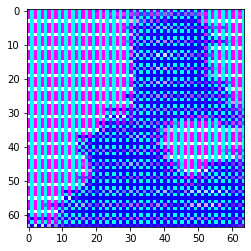

In [157]:
%matplotlib inline
import matplotlib.image as mpimg
img = mpimg.imread('/Users/zhudairun/Desktop/output/generated_img_000_0.png')
imgplot = plt.imshow(img)
plt.show()

And here is one from each epoch:

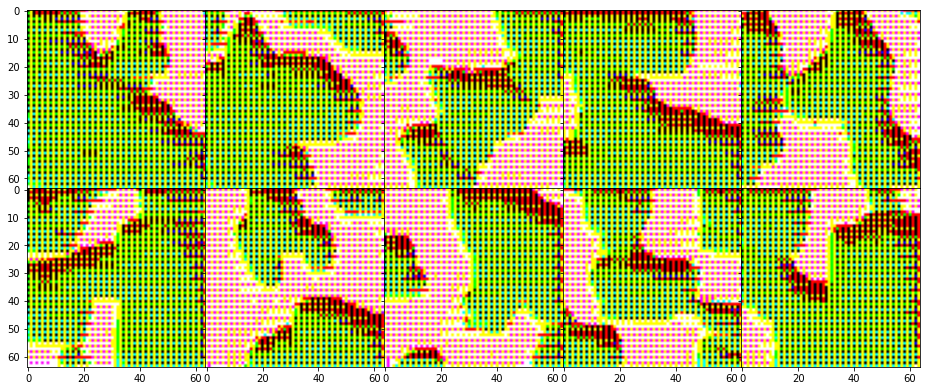

In [148]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"/Users/zhudairun/Desktop/output/generated_img_00{x}_0.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()